In [4]:
"""
Generate simulate TDEs  
"""

import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np


def flux_to_mag(flux):
    """
    Convert flux from milliJansky to AB Magnitude.
    """
    f_cgs = flux * 1e-3 * 1e-23  # mJy → Jy → erg/s/cm²/Hz
    mag = -2.5 * np.log10(f_cgs) - 48.6
    return mag


def mag_to_flux(mag):
    """
    Convert AB Magnitude to flux in milliJansky.
    """
    return np.power(10, (26 - (mag + 48.6) / 2.5))


def load_real_data(path):
    """
    Load and clean real object light curve data.
    """
    df = pd.read_csv(path)
    df = df[df["catflags"] == 0].copy()
    df["flux"] = mag_to_flux(df["mag"])
    return df


def load_tide_data(path):
    """
    Load the tidal flux model.
    """
    return pd.read_csv(path, header=None)


def preprocess_light_curve(df):
    """
    Sort and reset index for a single OID+Filter light curve.
    """
    return df.sort_values(by="mjd").reset_index(drop=True)


def simulate_flux_with_tide(real_df, tide_df):
    """
    Simulate a light curve by injecting a tidal flux signal into a real light curve.
    """
    if len(real_df) < 2:
        print("Not enough data points.")
        return

    start = random.randint(0, len(real_df) - 2)
    print(f"Random start index: {start}")

    real_df = real_df.copy()
    real_df["timedays"] = real_df["mjd"]
    real_df.loc[start:, "timedays"] = (real_df["mjd"].iloc[start:] - real_df["mjd"].iloc[start:].min()).round().astype(int)

    x1 = real_df['timedays'].iloc[start:-1].reset_index(drop=True)
    x2 = real_df['timedays'].iloc[start + 1:].reset_index(drop=True)
    valid = (x1 < len(tide_df)) & (x2 < len(tide_df))

    x1 = x1[valid]
    y1 = tide_df.iloc[x1.values, 0].reset_index(drop=True)
    flux_diff = y1.to_numpy()

    updated_flux = real_df['flux'].copy()
    updated_flux.iloc[start + 1:start + 1 + len(flux_diff)] += flux_diff

    real_df['simulated_flux'] = updated_flux
    real_df['simulated_mag'] = flux_to_mag(real_df['simulated_flux'])
    real_df['original_mag'] = flux_to_mag(real_df['flux'])

    plot_light_curves(real_df)


def plot_light_curves(df):
    """
    Plot original vs simulated magnitudes.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(df["mjd"], df["original_mag"], label="Original Mag", marker='o', alpha=0.7)
    plt.scatter(df["mjd"], df["simulated_mag"], label="Simulated Mag", marker='s', alpha=0.7)

    plt.title(f"Original vs Simulated Magnitude\nOID: {df['oid'].iloc[0]}, Filter: {df['filtercode'].iloc[0]}")
    plt.xlabel("Time (days)")
    plt.ylabel("AB Magnitude")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def process_all_light_curves(real_df, tide_df):
    """
    Process and simulate for all unique OID and Filter combinations.
    """
    for oid in real_df["oid"].unique():
        oid_data = real_df[real_df["oid"] == oid]
        for filt in oid_data["filtercode"].unique():
            filt_df = oid_data[oid_data["filtercode"] == filt]
            filt_df = preprocess_light_curve(filt_df)
            simulate_flux_with_tide(filt_df, tide_df)




Random start index: 348


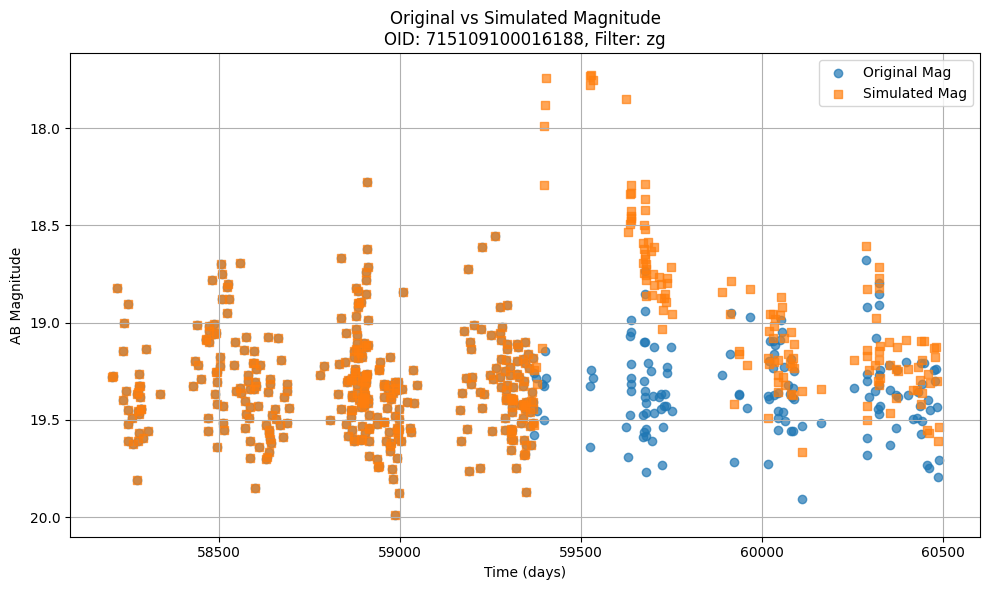

Random start index: 333


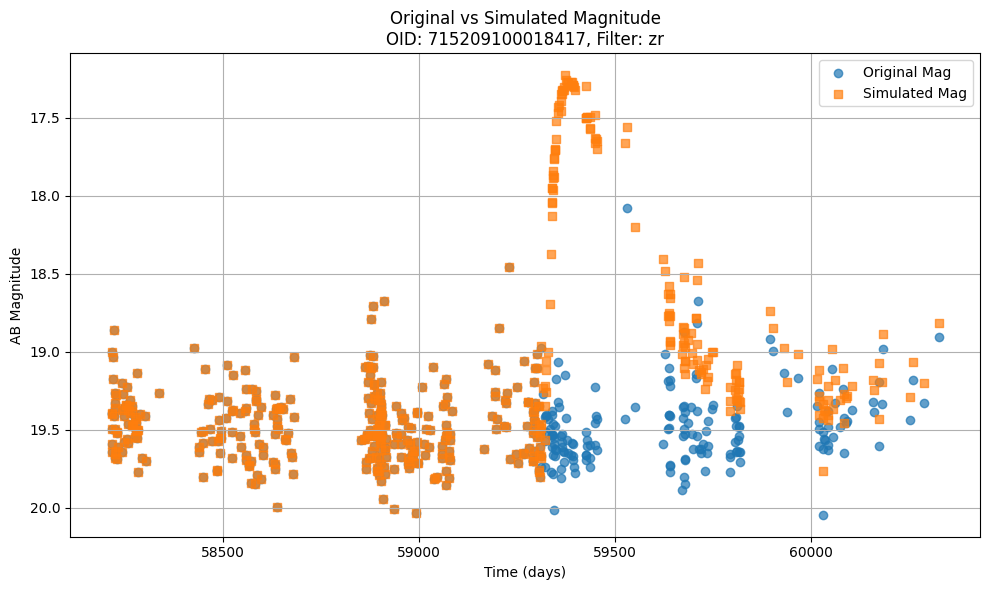

Random start index: 50


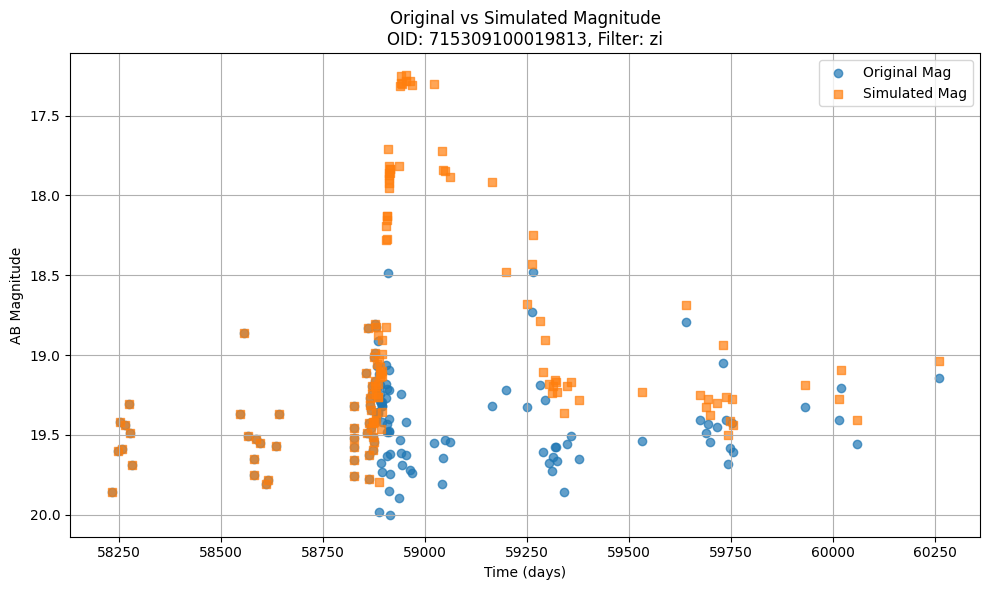

Random start index: 407


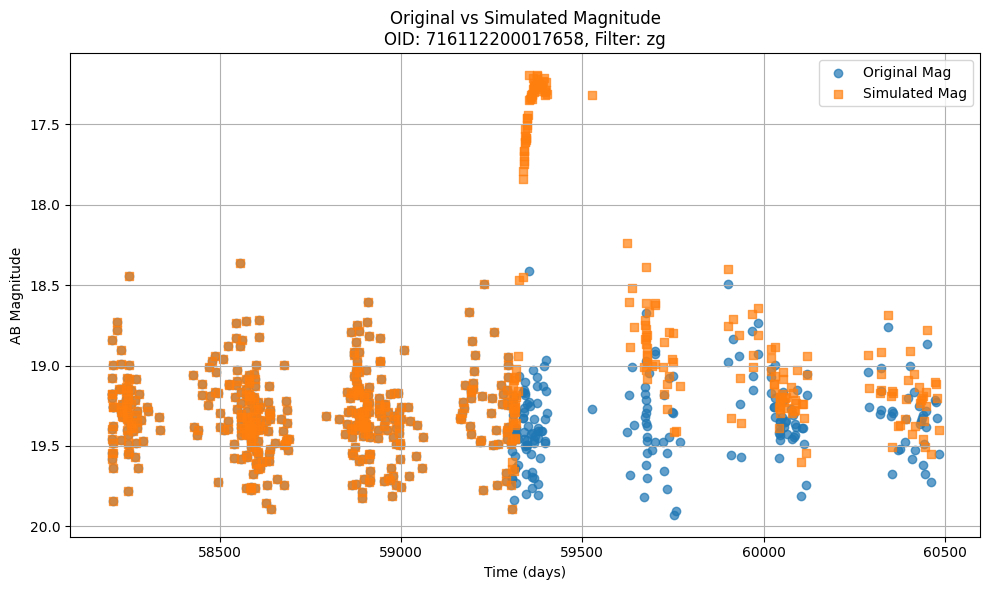

Random start index: 319


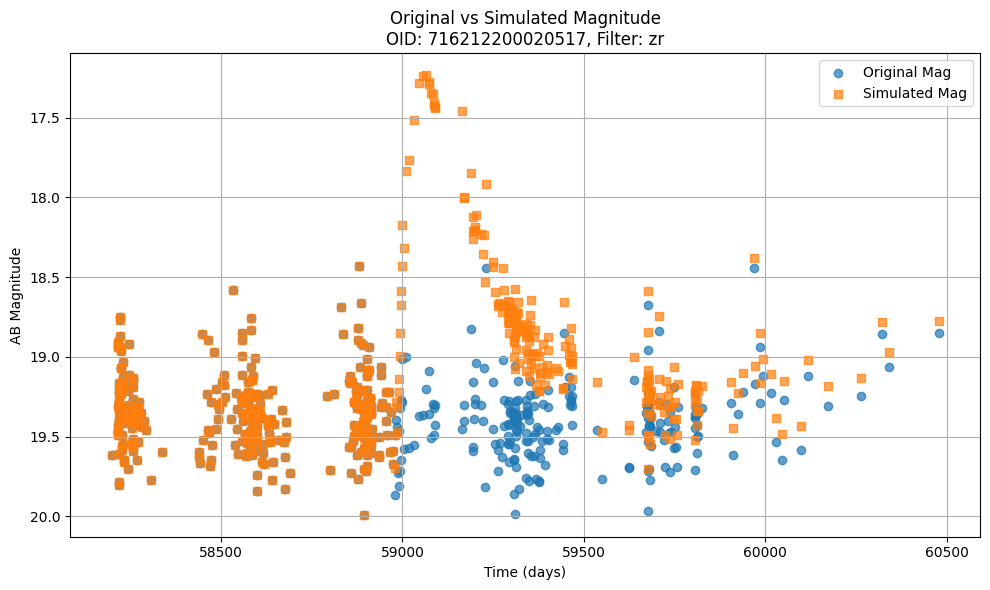

Random start index: 112


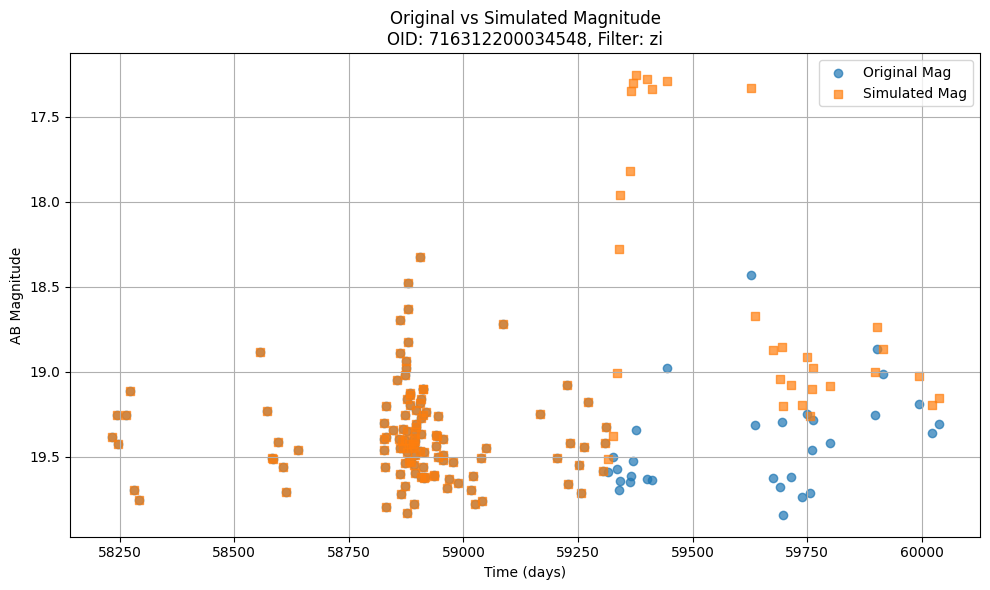

Random start index: 4


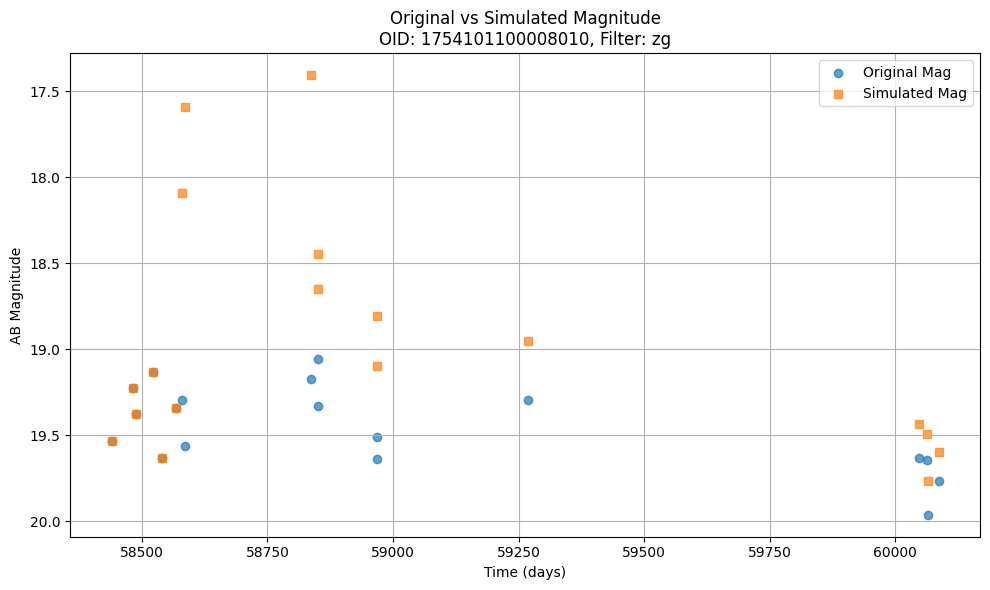

Random start index: 0


/var/folders/7t/d0qcn2md6w35fx4ys96nccw80000gn/T/ipykernel_2337/3580485026.py:64: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  real_df.loc[start:, "timedays"] = (real_df["mjd"].iloc[start:] - real_df["mjd"].iloc[start:].min()).round().astype(int)


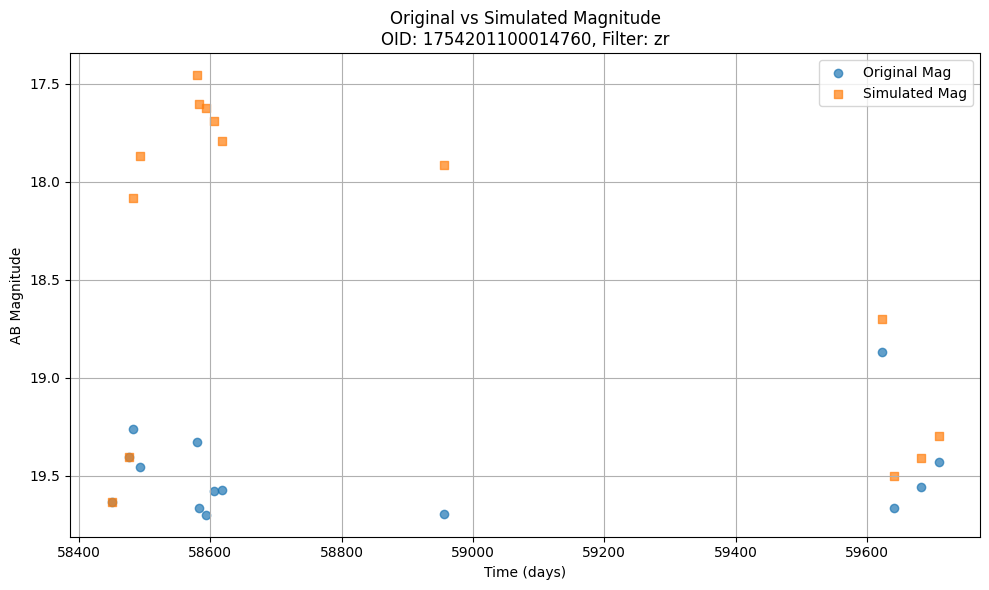

Random start index: 6


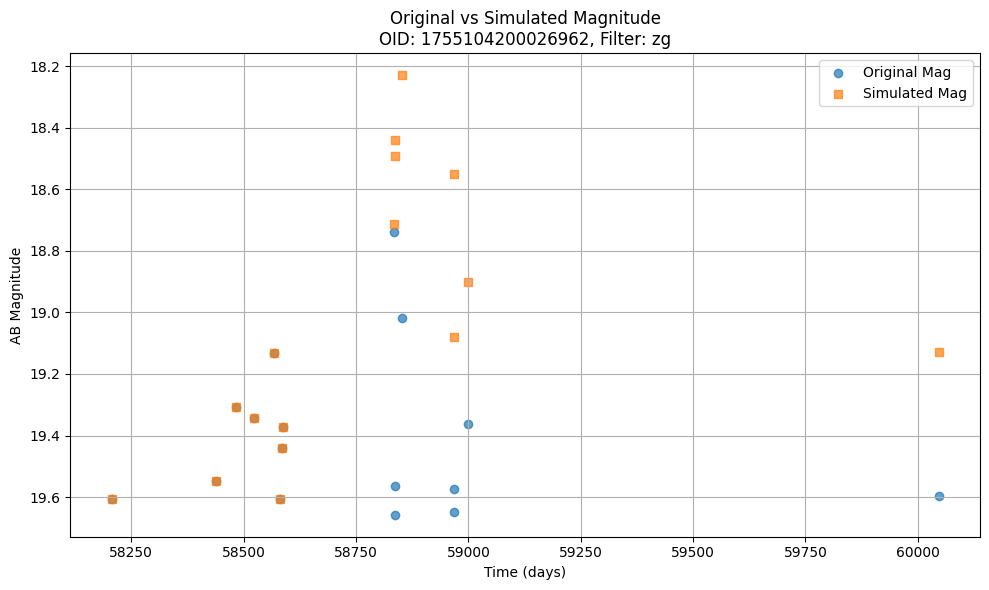

Random start index: 19


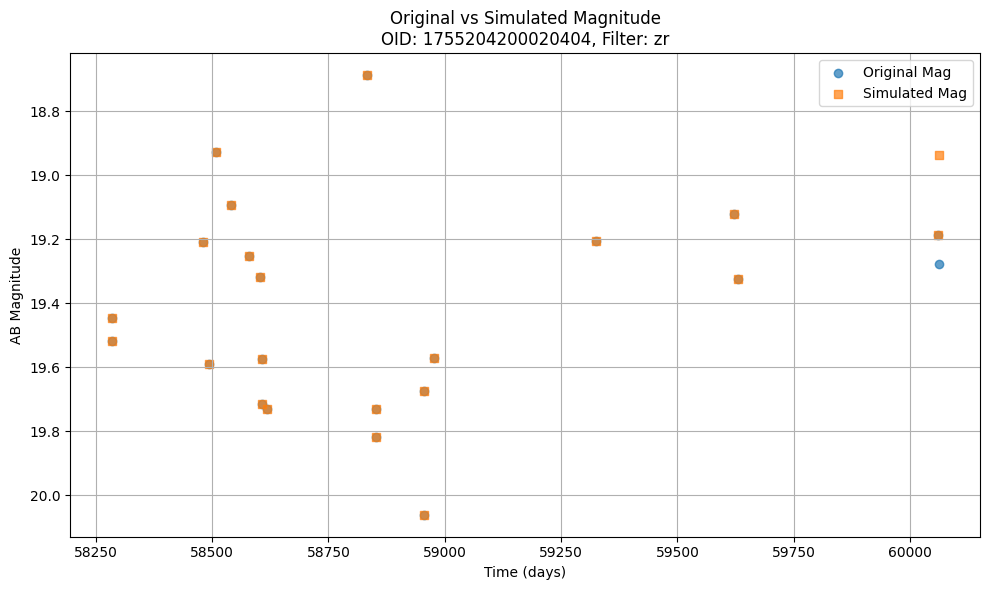

Processing complete.


In [5]:

def main():
    real_data_path = "data/ztf_irsa_input.csv"
    tide_data_path = "data/tide_flux_100mpc_scaling_with_p_nu.csv"

    real_df = load_real_data(real_data_path)
    tide_df = load_tide_data(tide_data_path)

    process_all_light_curves(real_df, tide_df)
    print("Processing complete.")


if __name__ == "__main__":
    main()